In [2]:
import pickle
import pandas as pd
import os
import setup

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
import pprint
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import MinMaxScaler
import math
from torch.profiler import profile, record_function, ProfilerActivity

from operator import itemgetter
import operator
from random import randint
# from rnn_classes import Dog, DogInput, Race, Races, GRUNet, smallGRUNet, smalll_lin_GRUNet, smalll_prelin_GRUNet
import rnn_tools.rnn_classes as rnn_classes
import json
import plotly.graph_objs as go

In [8]:
model_name = 'rosy-cosmos-156'
prev_model_version = 30

model_data = torch.load(f"C:/Users/Nick/Documents/GitHub/grvmodel/Python/pytorch/New Model/savedmodel/{model_name}/{model_name}_{prev_model_version}.pt", map_location=torch.device('cpu'))

In [6]:
print(model_data.keys())

dict_keys(['epoch', 'model_state_dict', 'optim', 'loss'])


In [9]:
total_size = 0
state_dict = model_data['model_state_dict']
for param_tensor in state_dict:
    tensor_obj = state_dict[param_tensor]
    total_size += tensor_obj.nelement() * tensor_obj.element_size()

print(f'Total size of state_dict: {total_size} bytes')

ValueError: Attempted to use an uninitialized parameter in <method 'numel' of 'torch._C._TensorBase' objects>. This error happens when you are using a `LazyModule` or explicitly manipulating `torch.nn.parameter.UninitializedParameter` objects. When using LazyModules Call `forward` with a dummy batch to initialize the parameters before calling torch functions

In [3]:
def kelly_criterion(odds, probabilities,D=0.95):
    """
    Calculate the Kelly Criterion bet sizes for multiple outcomes.

    Parameters:
    D (float): The dividend rate.
    odds (list): The odds for each outcome.
    probabilities (list): The estimated probability of each outcome.

    Returns:
    list: The fraction of the bankroll to bet on each outcome.
    """

    # Convert odds to decimal and calculate betas
    odds = [1 / o for o in odds]
    betas = [1 / o for o in odds]

    # Calculate the expected revenue rate for each outcome
    er = [(D * p) / b for p, b in zip(probabilities, betas)]

    # Initialize the set of outcomes to bet on and its revenue rate
    S = set()
    R_S = 1

    # Sort the outcomes by expected revenue rate in descending order
    outcomes = sorted(range(len(er)), key=lambda i: -er[i])

    for k in outcomes:
        # If the expected revenue rate of the k-th outcome is greater than the current revenue rate of the set...
        if er[k] > R_S:
            # ...then add the k-th outcome to the set and recalculate its revenue rate
            S.add(k)
            R_S = D * sum(probabilities[i] for i in range(len(probabilities)) if i not in S) / (D - sum(betas[i] for i in S))

    # Calculate the optimal fraction to bet on each outcome in the set
    f = [p - b * sum(probabilities[i] for i in range(len(probabilities)) if i not in S) / (D - sum(betas[i] for i in S)) if k in S else 0 for k, p, b in zip(range(len(probabilities)), probabilities, betas)]

    return f

def apply_kelly_to_df(df):
    # Group the DataFrame by raceid
    grouped = df.groupby('raceID')

    # Initialize a new column in the DataFrame for the Kelly ratios
    df['seq_kelly_ratio'] = 0.0

    # Iterate over each group
    for name, group in grouped:
        # Extract the odds and probabilities for this group
        odds = group['imp_prob'].tolist()
        probabilities = group['pred_prob'].tolist()

        # Calculate the dividend rate
        D = 1 - 0.07

        # Apply the Kelly Criterion to this group
        kelly_ratios = kelly_criterion(odds, probabilities, D=D)

        # Update the 'seq_kelly_ratio' column in the DataFrame for this group
        df.loc[group.index, 'seq_kelly_ratio'] = kelly_ratios

    return df

In [10]:
model_name  = 'stellar-resonance-277'
all_price_df = pd.read_feather(f'model_all_price/{model_name} - all_price_df.fth')
all_price_df
all_price_df2 = pd.read_feather(f'model_all_price/{model_name} - val_all_price_df.fth')
all_price_df = pd.concat([all_price_df, all_price_df2])

In [11]:
all_price_df.columns

Index(['index', 'raw_margins', 'correct', 'simple', 'win_price', 'relu',
       'bet_amount_model', 'output_price', 'pred_prob', 'pred_prob2', 'prices',
       'imp_prob', 'pred_price', 'pred_price1', 'pred_price2', 'classes',
       'track', 'onehot_win', 'dogID', 'dog_name', 'dog_box', 'raceID', 'date',
       'entropy', 'mutual_info', 'race_num', 'loss', 'loss_bfsp',
       'favorite_correct', 'one_hot_win', 'bet_amount', 'profit',
       'seq_kelly_ratio', 'bet_kelly_seq', 'profit_kelly_sq', 'colour',
       'profit < 30', 'outlay < 30', 'bet_amount2', 'profit2',
       'bet_amount_kelly', 'profit_kelly', 'profit < 30 2', 'outlay < 30 2',
       'bet_relu', 'profit_relu', 'bet_relu<30', 'profit_relu<30', 'kl_div',
       'kl_div_bfsp', 'win < 30', 'win', 'bet_count', 'bet_count < 30',
       'profit_model', 'round_price'],
      dtype='object')

0        2023-01-03
1        2023-01-03
2        2023-01-03
3        2023-01-03
4        2023-01-03
            ...    
14661    2023-12-10
14662    2023-12-10
14663    2023-12-10
14664    2023-12-10
14665    2023-12-10
Name: date, Length: 30432, dtype: object

In [53]:
all_price_df.to_excel(f'model_all_price/{model_name} - all_price_df.xlsx')

In [13]:
price_df  = all_price_df.groupby('round_price')[['bet_amount_model', 'profit_model']].sum().cumsum().reset_index()

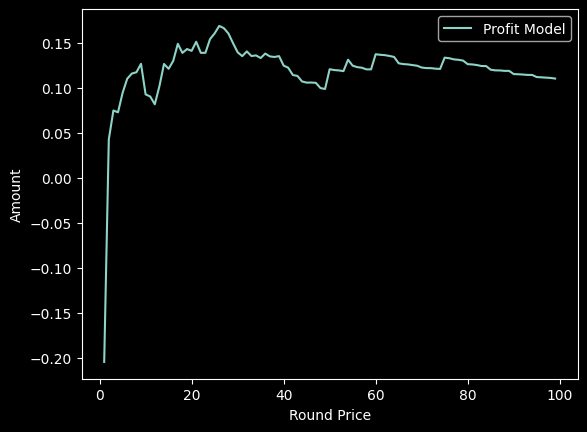

In [16]:
price_df['roi'] = price_df['profit_model'] / price_df['bet_amount_model']
price_df = price_df.query('round_price < 100.0')
# plt.plot(price_df['round_price'], price_df['bet_amount_model'], label='Bet Amount Model')
plt.plot(price_df['round_price'], price_df['roi'], label='Profit Model')
plt.xlabel('Round Price')
plt.ylabel('Amount')
plt.legend()
plt.show()


In [24]:
all_price_df['dt'] = pd.to_datetime(all_price_df['date']).dt.date

In [42]:
all_price_df = all_price_df.sort_values('dt',ascending=True)

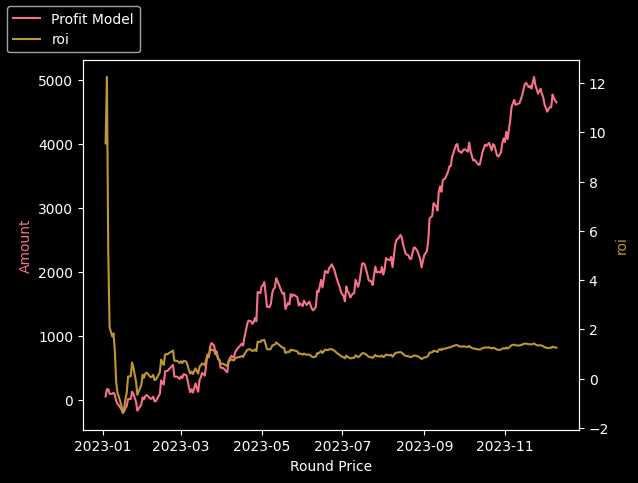

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn color palette as the default matplotlib color palette
sns.set_palette('husl')

# Your existing code
date = all_price_df.query('round_price < 10.0').copy()

date['bet_amount_model'] = np.where(date['bet_amount_model'] > 0.1, date['bet_amount_model'], 0)*2
date['profit_model'] = np.where(date['bet_amount_model'] > 0.1, date['profit_model'], 0)*10*2

date = date.groupby('dt',sort=False)[['bet_amount_model', 'profit_model','round_price']].sum().cumsum().reset_index()
date['roi'] = date['profit_model'] / date['bet_amount_model']

# Create a figure and a single axis
fig, ax1 = plt.subplots()

# Plot the 'Profit Model' on the first axis
color = sns.color_palette()[0]
ax1.plot(date['dt'], date['profit_model'], label='Profit Model', color=color)
ax1.set_xlabel('Round Price')
ax1.set_ylabel('Amount', color=color)

# Create a second axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'roi' on the second axis
color = sns.color_palette()[1]
ax2.plot(date['dt'], date['roi'], label='roi', color=color)
ax2.set_ylabel('roi', color=color)

# Show the legend
fig.legend(loc="upper left")

# Show the plot
plt.show()

In [36]:
df = apply_kelly_to_df(all_price_df)

In [37]:
df = df[[col for col in df.columns if '2' not in col and '<' not in col]]

In [38]:
df['bet_kelly_seq'] = np.where(
    df['prices']<30,
    df['seq_kelly_ratio']*100,
    0
)


df['profit_kelly_sq'] = np.where(
    df['onehot_win'],
    df['bet_kelly_seq']  * (df['prices'] - 1) * 0.95,
    -1 * df['bet_kelly_seq']
)

C:\Users\Nick\AppData\Local\Temp\ipykernel_22208\2227054136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bet_kelly_seq'] = np.where(
C:\Users\Nick\AppData\Local\Temp\ipykernel_22208\2227054136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit_kelly_sq'] = np.where(


In [41]:
df_30 = df[df['prices']<30]

In [42]:
df_30['profit_kelly_sq'].sum()/df_30['bet_kelly_seq'].sum()

-0.014917079482063344

In [43]:
df_30['profit_kelly'].sum()/df_30['bet_amount_kelly'].sum()

-0.05251907582272744

In [2]:
json_path = 'wandb_jsons/dancing-snake-80' 
files = os.listdir(json_path)
file_paths = [json_path + '/' + file for file in files]

for i,file in enumerate(file_paths):
    with open(file, 'r') as f:
        json_obj = json.load(f)

    # Create a DataFrame from the dictionary
    if i == 0:
        data = pd.DataFrame(data=json_obj["data"], columns=json_obj["columns"])
        data['step'] = i
    else:
        df = pd.DataFrame(data=json_obj["data"], columns=json_obj["columns"])
        df['step'] = i
        data = pd.concat([data, df])

In [3]:
data

,index,imp_prob,pred_prob,loss,onehot_win,mutual_info,step
0,0,0.284379,0.207907,0.314357,0.0,0.038062,0
1,1,0.339898,0.262791,0.059681,0.0,0.038062,0
2,2,0.060364,0.154242,0.001133,0.0,0.038062,0
3,3,0.037303,0.087363,0.024290,0.0,0.038062,0
4,4,0.069744,0.087032,0.022013,0.0,0.038062,0
...,...,...,...,...,...,...,...
9995,13010,0.050000,0.055298,0.000108,0.0,0.027519,98
9996,13011,0.052632,0.062132,0.278702,0.0,0.027519,98
9997,13012,0.041667,0.030744,0.316037,0.0,0.027519,98
9998,13013,0.128205,0.074162,0.005282,0.0,0.027519,98


In [4]:
df.filter

<bound method NDFrame.filter of       index  imp_prob  pred_prob      loss  onehot_win  mutual_info  step
0         0  0.284379   0.216534  0.306220         0.0     0.041786    98
1         1  0.339898   0.291799  0.055005         0.0     0.041786    98
2         2  0.060364   0.139676  0.001193         0.0     0.041786    98
3         3  0.037303   0.062424  0.027640         0.0     0.041786    98
4         4  0.069744   0.075048  0.023349         0.0     0.041786    98
...     ...       ...        ...       ...         ...          ...   ...
9995  13010  0.050000   0.055298  0.000108         0.0     0.027519    98
9996  13011  0.052632   0.062132  0.278702         0.0     0.027519    98
9997  13012  0.041667   0.030744  0.316037         0.0     0.027519    98
9998  13013  0.128205   0.074162  0.005282         0.0     0.027519    98
9999  13014  0.076923   0.084374  0.136110         0.0     0.027519    98

[10000 rows x 7 columns]>

In [8]:
df = data
df = data.query('onehot_win ==1')
# df = df.head(1000)

# Create a scatter plot for each step
# Create a scatter plot for each step
# Create a scatter plot for each step using Scattergl for WebGL
traces = [go.Scattergl(
    x=df['loss'][df['step'] == step].head(100),
    y=df['mutual_info'][df['step'] == step].head(100),
    mode='markers',
    visible=False,
    name=f'Step {step}'
) for step in df['step'].unique()]

# Make the first trace visible
traces[0]['visible'] = True

x_range = [df['loss'].min(), df['loss'].max()]
y_range = [df['mutual_info'].min(), df['mutual_info'].max()]

# Create a layout with a slider
layout = go.Layout(
    title='Loss vs Mutual Info',
    xaxis=dict(title='Loss'),
    yaxis=dict(title='Mutual Info'),
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "Step: "},
        pad={"t": 50},
        steps=[dict(method='update',
                    args=[{'visible': [s == step for s in df['step'].unique()]}],
                    label=str(step)) for step in df['step'].unique()]
    )]
)

# Create a Figure
fig = go.Figure(data=traces, layout=layout)

# Display the figure
fig.show()